#Option Valuation Project


In [1]:
# import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import norm
from math import exp, sqrt, inf
import math

##1. Monte Carlo Simulation

(a) Compute the price of the following options using Monte Carlo Simulation with the sample size 250 or larger.
1. Asian call
2. Asian put
3. Lookback call
4. Lookback put
5. Floating lookback call
6. Floating lookback put
Assume that the risk-free rate is 2%, the underlying stock has the current price 100 dollars, and volatility 25%, with no dividend payments. All the options have a strike price 105 dollars and the maturity 2 months. The simulation has the unit time = 1 week.


In [2]:
S0 = 100     # current price of the underlying stock
K = 105      # strike price
sigma = 0.25  # volatility
r = 0.02     # risk-free rate
T = 1/6      # maturity (years)
numSteps = 8 # 2 months = 8 weeks
numPaths = 10000

In [3]:
paths = np.zeros((numSteps + 1, numPaths))

# dT is the time increment (in years)
dT = T / numSteps

# First asset price is the initial price
paths[0] = [S0] * numPaths

# Monte Carlo simulations
for iPath in range(numPaths):
    for iStep in range(numSteps):
        paths[iStep + 1, iPath] = paths[iStep, iPath] * np.exp((r - 0.5 * sigma ** 2) * dT 
                                                                   + sigma * np.sqrt(dT) * np.random.normal(0,1))

# Asian Option
CallPayoffT_asian = np.maximum(np.mean(paths, axis = 0) - K, 0)
PutPayoffT_asian = np.maximum(K - np.mean(paths, axis = 0), 0)

c_asian = np.mean(CallPayoffT_asian)* np.exp(-r * T)
p_asian = np.mean(PutPayoffT_asian)* np.exp(-r * T)

# Lookback Option
CallPayoffT_lookback = np.maximum(np.max(paths, axis = 0) - K, 0)
PutPayoffT_lookback = np.maximum(K - np.min(paths, axis = 0), 0)

c_lookback = np.mean(CallPayoffT_lookback)* np.exp(-r * T)
p_lookback = np.mean(PutPayoffT_lookback)* np.exp(-r * T)

# Floating Lookback Option
CallPayoffT_float = np.maximum(paths[-1, :] - np.min(paths, axis = 0), 0)
PutPayoffT_float = np.maximum(np.max(paths, axis = 0) - paths[-1, :], 0)

c_float = np.mean(CallPayoffT_float)* np.exp(-r * T)
p_float = np.mean(PutPayoffT_float)* np.exp(-r * T)


print('Asian call price:', c_asian, 'Asian put price:', p_asian)
print('Lookback call price:', c_lookback ,'Lookback put price:', p_lookback)
print('Floating lookback call price', c_float, 'Floating lookback put price', p_float)

Asian call price: 0.6732117257677442 Asian put price: 5.476919377514009
Lookback call price: 3.3714831197076656 Lookback put price: 11.001314820649789
Floating lookback call price 6.329439944394341 Floating lookback put price 6.31925622351452


Text(0.5, 1.0, 'Geometric Random Paths of Monte Carlo Simulation for Stock Price')

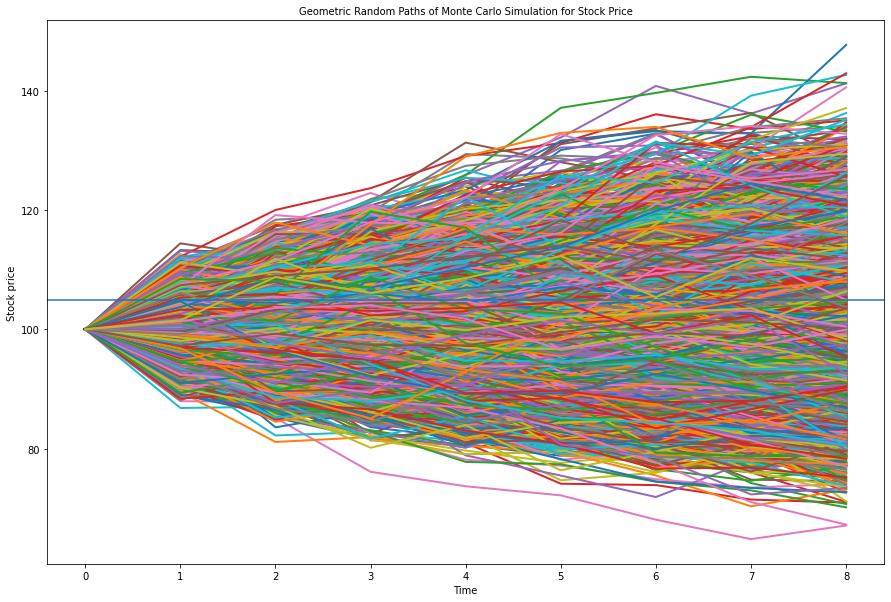

In [4]:
# plot of Monte Carlo simulations
plt.figure(figsize = (15, 10))
plt.plot(paths[:,:-1], linewidth=2)
plt.axhline(K, xmin=0, xmax=8)

plt.xlabel('Time', fontsize = 10)
plt.ylabel('Stock price', fontsize = 10)
plt.title('Geometric Random Paths of Monte Carlo Simulation for Stock Price', fontsize = 10)

(b) Also price an American put option using Monte Carlo Simulation

In [5]:
# American Put Option
PutPayoffT_American = []

paths = np.zeros((numSteps + 1, numPaths))

# dT is the time increment (in years)
dT = T / numSteps
paths[0] = [S0] * numPaths

for iPath in range(numPaths):
  for iStep in range(numSteps):
    stop_time = iStep * dT
    time_left = T - stop_time
    paths[iStep + 1, iPath] = paths[iStep, iPath] * np.exp((r - 0.5 * sigma ** 2) * dT 
                                                                   + sigma * np.sqrt(dT) * np.random.normal(0,1))
    # Black Scholes
    if time_left != 0:
      d1 = (np.log(paths[iStep + 1, iPath] / K) + ( r + 0.5 * (sigma**2))*time_left) / (sigma * np.sqrt(time_left))
      d2 = d1 - (sigma * np.sqrt(time_left))
      # Price of American put premium
      putpremium_American = K * np.exp(-r * time_left) * norm.cdf(-d2,0,1) - paths[iStep + 1, iPath] * norm.cdf(-d1, 0, 1)

    else:
      # Price of American put premium at T
      putpremium_American = 0 if paths[iStep + 1, iPath] > K else - paths[iStep + 1, iPath]

    # Payoff of put option
    PutPayoff = np.maximum (K - paths[iStep + 1, iPath], 0)
    if PutPayoff > putpremium_American: break
  
  # payoff discounted
  PutPayoffT_American.append(PutPayoff * np.exp (-r * stop_time))

# American put option price
price_put_American = np.mean(PutPayoffT_American)
print('American put option price:', price_put_American)

American put option price: 6.944670294640814


 ## 2.Lattice


Solve Question 1 again using the lattice approach.

(c) Compute the price of the following options using the lattice approach.
1. Asian call
2. Asian put
3. Lookback call
4. Lookback put
5. Floating lookback call
6. Floating lookback put

In [6]:
rf=0.02
S0=100
volatility=0.25
K=105
maturity_month=2
maturity_yr=2/12
unit_time=4
step=unit_time * maturity_month # 4*2-->8
dt=maturity_yr/step #(1/6)/8 --> 1/48

In [7]:
u=np.exp(volatility*np.sqrt(dt)) #upward multiplication factor
d=1/u #downward multiplication factor
R=np.exp(rf*dt) 
q=(R-d)/(u-d) 

In [8]:
n=step
# lattice paths

# Go through all the possible paths
S_T = []
S_avg = []
S_max = []
S_min = []
weights = []

for i in range(2**step):
    lattice_path = ('{:0'+str(step)+'b}').format(i)
    #print(lattice_path) ## check the possible paths
    S = [S0]
    w = 1
    for i in lattice_path:
        if i == '1':
            S.append(S[-1]*u)
            w *= q
        else:
            S.append(S[-1]*d)
            w *= 1-q

    S_T.append(S[-1])
    S_max.append(max(S))
    S_min.append(min(S))
    S_avg.append(sum(S)/len(S))
    weights.append(w)

In [9]:
# 1.Asian call option 
asian_call_price = exp(-rf*dt) * sum([weights[i] * max(S_avg[i]-K, 0) for i in range(2**step)])
print("The price of Asian Call:",asian_call_price)

The price of Asian Call: 0.6945123670605255


In [10]:
# 2.Asian put option 
asian_put_price = exp(-rf*dt) * sum([weights[i] * max(K-S_avg[i], 0) for i in range(2**step)])
print("The price of Asian put:",asian_put_price)

The price of Asian put: 5.525635380052349


In [11]:
#3.lookback call option
lookback_call_price = exp(-rf*dt) * sum([weights[i] * max(S_max[i]-K, 0) for i in range(2**step)])
print("The price of lookback call:",lookback_call_price)

The price of lookback call: 3.585405765760444


In [12]:
#4.lookback put option
lookback_put_price = exp(-rf*dt) * sum([weights[i] * max(K-S_min[i], 0) for i in range(2**step)])
print("The price of lookback put:",lookback_put_price)

The price of lookback put: 11.281357194687569


In [13]:
#5.floating lookback call option
floating_lookback_call = exp(-rf*dt) * sum([weights[i] * max(S_T[i]-S_min[i], 0) for i in range(2**step)])
print("The price of floating lookback call :",floating_lookback_call)

The price of floating lookback call : 6.6171905090926435


In [14]:
#6. floating lookback put option
floating_lookback_put = exp(-rf*dt) * sum([weights[i] * max(S_max[i]-S_T[i], 0) for i in range(2**step)])
print("The price of floating lookback put :",floating_lookback_put)

The price of floating lookback put : 6.566966637607401


d) American put option

In [15]:
# stock price of all possible time spots
stock_prices = [[S0]]  
for i in range(1, step+1):
    price_temp = []
    for path in range(2**i):
        last_step_price = stock_prices[i- 1][path // 2]
        if path % 2 == 0:
            price_temp.append(last_step_price * u)
        else:
            price_temp.append(last_step_price * d)
    stock_prices.append(price_temp)
print(stock_prices)

[[100], [103.67433354606588, 96.45588891638907], [107.48367436220921, 100.0, 100.0, 93.03738506650788], [111.43298306584407, 103.67433354606588, 103.67433354606588, 96.45588891638907, 103.67433354606588, 96.45588891638907, 96.45588891638907, 89.740036790464], [115.5274025440143, 107.4836743622092, 107.48367436220921, 100.0, 107.48367436220921, 100.0, 100.0, 93.03738506650788, 107.48367436220921, 100.0, 100.0, 93.03738506650788, 100.0, 93.03738506650788, 93.03738506650788, 86.55955020013664], [119.77226465058757, 111.43298306584407, 111.43298306584406, 103.67433354606587, 111.43298306584407, 103.67433354606588, 103.67433354606588, 96.45588891638907, 111.43298306584407, 103.67433354606588, 103.67433354606588, 96.45588891638907, 103.67433354606588, 96.45588891638907, 96.45588891638907, 89.740036790464, 111.43298306584407, 103.67433354606588, 103.67433354606588, 96.45588891638907, 103.67433354606588, 96.45588891638907, 96.45588891638907, 89.740036790464, 103.67433354606588, 96.455888916389

In [16]:
# the option price of all possible time spots
option_prices = [] 
# the optimal decision at each node, 'E' for exercising, 'W' for waiting
# the optimal decision at each node, 'E' for exercising
decisions = [['E']*2**step]
max_exercising = [-inf]*step
min_waiting = [inf]*step
# at maturity T (= num_steps), the price is the payoff
prices_temp = []
for path in range(2**step):
    prices_temp.append(max(0, K - stock_prices[step][path]))
option_prices.append(prices_temp)

In [17]:
print(option_prices)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.000000000000014, 0, 0, 0, 0, 0, 0, 0, 5.000000000000028, 0, 0, 0, 5.000000000000014, 0, 5.000000000000014, 5.000000000000014, 11.962614933492134, 0, 0, 0, 0, 0, 0, 0, 5.000000000000014, 0, 0, 0, 5.0, 0, 5.0, 5.0, 11.96261493349212, 0, 0, 0, 5.0, 0, 5.0, 5.0, 11.96261493349212, 0, 5.0, 5.0, 11.96261493349212, 5.0, 11.96261493349212, 11.96261493349212, 18.44044979986336, 0, 0, 0, 0, 0, 0, 0, 5.000000000000014, 0, 0, 0, 5.0, 0, 5.0, 5.0, 11.96261493349212, 0, 0, 0, 5.0, 0, 5.0, 5.0, 11.96261493349212, 0, 5.0, 5.0, 11.96261493349212, 5.0, 11.96261493349212, 11.96261493349212, 18.44044979986336, 0, 0, 0, 5.0, 0, 5.0, 5.0, 11.96261493349212, 0, 5.0, 5.0, 11.96261493349212, 5.0, 11.96261493349212, 11.96261493349212, 18.44044979986336, 0, 5.0, 5.0, 11.96261493349212, 5.0, 11.96261493349212, 11.96261493349212, 18.44044979986336, 5.0, 11.96261493349212, 11.96261493349212, 18.44044979986336, 11.962614933492134, 18.44044979986336, 18.44044979986336,

In [18]:
# before maturity T (< num_steps), the price is the max of payoff at num_steps (exercising) or the PV of expected price at num_steps+1 (waiting)
for time_step in range(step-1, -1, -1):
    prices_temp = []
    decisions_temp = []

    for path in range(2**time_step):
        exercising_profit = max(0, K - stock_prices[time_step][path])
        waiting_profit = exp(-rf*dt) * (q*option_prices[-1][2*path] + (1-q)*option_prices[-1][2*path+1])
        prices_temp.append(max(exercising_profit, waiting_profit))
        
        # 'E' for exercising, 'W' for waiting
        if waiting_profit - exercising_profit > -0.001:
            decisions_temp.append('W')
            min_waiting[time_step] = min(stock_prices[time_step][path], min_waiting[time_step])
        else:
            decisions_temp.append('E')
            max_exercising[time_step] = max(stock_prices[time_step][path], max_exercising[time_step])

    option_prices.append(prices_temp)
    decisions.append(decisions_temp)

In [19]:
print("The price of American put:",option_prices[-1][0])

The price of American put: 7.032165964144476
